In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import scipy.stats as st
import joblib

from scipy.stats import t
from sklearn import datasets
from random import choices
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import confusion_matrix, f1_score, matthews_corrcoef, mean_squared_error, ConfusionMatrixDisplay, accuracy_score

In [2]:
def main():
    
    prot_embeddings_in = 'protein_embeddings_enzymes_non_enzymes.h5'

    # read per-protein embeddings into a dictionary with key: Uniprot id, value: 1024-d embedding
    counter = 0
    prot_embeddings = dict()
    with h5py.File(prot_embeddings_in, 'r') as f:
        for key, embedding in f.items():
            original_id = embedding.attrs['original_id']
            prot_embeddings[original_id] = np.array(embedding)
    return prot_embeddings

enzyme_embeddings = pd.DataFrame.from_dict(main())

In [3]:
annotations = pd.read_csv('Data_set/ec_annotations_single.tab', sep='\t')
annotations['EC number'] = annotations['EC number'].str[:1]
test = pd.read_table('Data_set/test_set.fasta', sep='\n', skiprows=lambda x: (x != 0) and not x % 2 == 0)
head = test.columns
test.loc[-1] = head[0]
test.reset_index(drop=True, inplace=True)
test.rename(columns={head[0]: 'Entry'}, inplace=True)
test['Entry'] = test['Entry'].str[1:]
test_embeddings = (((enzyme_embeddings[enzyme_embeddings.columns.intersection(test['Entry'].tolist())]).T).reset_index(level=0)).rename(columns={'index': 'Entry'})
test_embeddings['Annotation'] = np.full(600, 0)

In [4]:
X_test = pd.merge(test_embeddings, annotations)
X_test

,Entry,0,1,2,3,4,5,6,7,8,...,1016,1017,1018,1019,1020,1021,1022,1023,Annotation,EC number
0,Q23551,-0.005463,-0.053955,0.024017,0.004925,-0.010223,-0.021545,-0.036194,-0.039612,0.056793,...,0.017212,-0.112305,0.050507,-0.000987,0.086426,0.096558,0.124634,0.062683,0,2
1,P53632,0.008476,-0.066650,0.019241,0.033508,0.016891,0.017151,-0.094849,-0.065125,0.015640,...,-0.047028,-0.024170,0.037384,0.001676,-0.038483,-0.004570,-0.021820,0.010796,0,2
2,P14284,0.017029,-0.030182,-0.033417,0.026154,-0.021500,0.030212,-0.090332,-0.041473,-0.020493,...,0.004028,-0.010201,0.039886,0.055573,-0.015625,0.031372,-0.035278,0.036713,0,2
3,Q8YYI3,-0.018173,0.068054,0.023499,-0.059235,0.015411,0.022018,-0.036102,-0.100342,-0.026337,...,0.057526,-0.102417,0.004776,0.043427,-0.028534,0.008537,-0.024139,-0.002893,0,4
4,Q8XIQ9,0.027771,0.005833,0.011559,0.006126,-0.033936,0.011063,-0.041565,-0.105469,0.012451,...,0.017365,-0.083801,0.049316,0.022003,-0.016159,0.015602,0.028809,0.020493,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,Q23652,0.013107,-0.038788,-0.004993,0.045685,0.021057,0.032440,-0.058960,-0.081970,-0.008781,...,-0.023758,-0.020493,0.031052,0.000690,-0.025497,-0.038971,0.053436,0.025726,0,2
184,Q5P5G2,0.011879,0.002283,0.022659,0.033386,-0.004322,0.003750,-0.024979,-0.052155,-0.034912,...,0.024933,-0.066162,0.012932,0.028061,0.003183,-0.025040,0.029861,0.014526,0,6
185,P40308,-0.001348,-0.064453,-0.027145,0.005970,0.025345,0.024612,-0.051971,-0.061829,-0.035431,...,-0.034546,-0.008377,0.036713,0.065186,0.029343,0.025482,-0.003437,0.032288,0,3
186,Q54JL7,0.110535,0.090454,0.095154,-0.081909,0.135620,-0.052032,0.069397,-0.117737,-0.075195,...,-0.097290,-0.092285,0.100403,-0.063171,-0.041382,-0.056763,0.044739,0.057617,0,3


In [5]:
enzymeid = np.array(X_test['Entry'])
ec = np.array(X_test['EC number'])
for i in range(len(enzymeid)):
    test_embeddings.loc[(test_embeddings.Entry == enzymeid[i]), 'Annotation'] = ec[i]
test_embeddings

,Entry,0,1,2,3,4,5,6,7,8,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,Annotation
0,Q23551,-0.005463,-0.053955,0.024017,0.004925,-0.010223,-0.021545,-0.036194,-0.039612,0.056793,...,0.010468,0.017212,-0.112305,0.050507,-0.000987,0.086426,0.096558,0.124634,0.062683,2
1,Q8BP00,0.000461,-0.047516,0.053253,0.038818,-0.022827,0.046814,-0.050629,-0.064758,0.083618,...,-0.018417,0.005608,0.001245,-0.021057,-0.014687,-0.033997,-0.007027,-0.031021,0.019989,0
2,Q9P7T9,-0.006588,0.015068,0.035553,0.041412,-0.001978,0.060211,-0.030640,-0.085144,-0.014259,...,-0.024506,-0.034973,-0.072205,0.062317,-0.000457,0.008232,-0.002293,0.047699,-0.018570,0
3,Q914H6,0.024078,0.039185,0.121399,-0.037262,0.077942,-0.022293,-0.031128,-0.062683,0.074829,...,0.007404,0.028549,-0.045380,0.055634,0.055298,-0.055756,-0.080505,-0.025146,0.029816,0
4,P53632,0.008476,-0.066650,0.019241,0.033508,0.016891,0.017151,-0.094849,-0.065125,0.015640,...,0.025970,-0.047028,-0.024170,0.037384,0.001676,-0.038483,-0.004570,-0.021820,0.010796,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,Q9SJK9,-0.009712,0.023651,0.019409,-0.042145,0.017044,0.042084,0.018631,-0.093079,0.049530,...,-0.058685,0.013794,-0.034637,0.056610,-0.021179,0.019547,0.023270,0.056671,0.011406,0
596,Q8SVP8,0.012207,-0.101685,0.039032,0.010468,-0.032501,0.044556,0.016556,-0.117615,0.004448,...,-0.013199,0.030090,-0.067810,0.021408,0.019775,0.040619,0.043732,0.027161,0.062317,0
597,C0LT23,0.043365,0.007950,0.026230,0.004196,0.051941,0.078857,-0.013664,-0.045105,0.082825,...,-0.018845,0.038177,-0.029510,0.024780,-0.039185,0.003586,0.009338,0.048798,0.001344,2
598,Q9US39,0.015572,-0.009689,0.022690,0.037903,0.027802,0.014221,-0.091919,-0.068115,0.009735,...,0.002794,-0.002123,-0.013306,0.060699,0.013039,0.019211,-0.044983,0.034485,0.049133,0


In [6]:
enznonenz = joblib.load('non_enzyme')
enzyme_pred = enznonenz.predict(test_embeddings.drop(columns=['Entry', 'Annotation']))
test_embeddings['1Pred'] = enzyme_pred

In [7]:
X_test_pp = (test_embeddings.loc[test_embeddings['1Pred'] == 1]).drop(columns=['1Pred'])
test_embeddings_nonenz = test_embeddings.loc[test_embeddings['1Pred'] == 0]
test_embeddings_nonenz

,Entry,0,1,2,3,4,5,6,7,8,...,1016,1017,1018,1019,1020,1021,1022,1023,Annotation,1Pred
1,Q8BP00,0.000461,-0.047516,0.053253,0.038818,-0.022827,0.046814,-0.050629,-0.064758,0.083618,...,0.005608,0.001245,-0.021057,-0.014687,-0.033997,-0.007027,-0.031021,0.019989,0,0
2,Q9P7T9,-0.006588,0.015068,0.035553,0.041412,-0.001978,0.060211,-0.030640,-0.085144,-0.014259,...,-0.034973,-0.072205,0.062317,-0.000457,0.008232,-0.002293,0.047699,-0.018570,0,0
3,Q914H6,0.024078,0.039185,0.121399,-0.037262,0.077942,-0.022293,-0.031128,-0.062683,0.074829,...,0.028549,-0.045380,0.055634,0.055298,-0.055756,-0.080505,-0.025146,0.029816,0,0
5,Q4P5V5,-0.037415,0.001999,0.042084,0.057983,0.031891,-0.057739,-0.016403,-0.099487,0.017944,...,-0.040466,0.061218,-0.009071,0.016327,-0.038727,-0.065918,0.017838,0.097351,0,0
6,O74485,-0.005409,-0.077209,-0.003910,0.057159,-0.061279,0.053040,-0.019043,-0.076477,0.021835,...,0.028152,-0.002628,-0.002695,0.008919,-0.079529,-0.028976,0.017120,-0.004456,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591,Q8BVM2,0.001235,0.037506,0.094543,0.001629,-0.057037,0.049286,-0.085815,-0.060699,0.041290,...,-0.010429,-0.088989,0.033173,0.041687,-0.012451,-0.046875,0.053589,0.024551,0,0
592,Q1HVF7,0.091492,0.027802,0.088989,-0.040222,0.053650,-0.045746,0.096985,-0.113342,-0.016006,...,-0.017105,-0.070862,-0.063965,-0.078491,-0.009178,0.058350,0.094055,0.038696,0,0
594,Q54Q48,0.069763,0.026199,0.060089,0.003441,0.056335,0.016556,-0.061798,-0.077881,-0.001051,...,-0.018860,-0.010986,0.089905,-0.089111,-0.099243,-0.001922,0.004826,0.044098,0,0
595,Q9SJK9,-0.009712,0.023651,0.019409,-0.042145,0.017044,0.042084,0.018631,-0.093079,0.049530,...,0.013794,-0.034637,0.056610,-0.021179,0.019547,0.023270,0.056671,0.011406,0,0


In [8]:
perprotein = joblib.load('final-per-protein')
perprotein_pred = perprotein.predict(X_test_pp.drop(columns=['Entry', 'Annotation']))

In [9]:
X_test_pp['1Pred'] = perprotein_pred
X_test_pp

,Entry,0,1,2,3,4,5,6,7,8,...,1016,1017,1018,1019,1020,1021,1022,1023,Annotation,1Pred
0,Q23551,-0.005463,-0.053955,0.024017,0.004925,-0.010223,-0.021545,-0.036194,-0.039612,0.056793,...,0.017212,-0.112305,0.050507,-0.000987,0.086426,0.096558,0.124634,0.062683,2,6
4,P53632,0.008476,-0.066650,0.019241,0.033508,0.016891,0.017151,-0.094849,-0.065125,0.015640,...,-0.047028,-0.024170,0.037384,0.001676,-0.038483,-0.004570,-0.021820,0.010796,2,2
12,P14284,0.017029,-0.030182,-0.033417,0.026154,-0.021500,0.030212,-0.090332,-0.041473,-0.020493,...,0.004028,-0.010201,0.039886,0.055573,-0.015625,0.031372,-0.035278,0.036713,2,2
13,Q8YYI3,-0.018173,0.068054,0.023499,-0.059235,0.015411,0.022018,-0.036102,-0.100342,-0.026337,...,0.057526,-0.102417,0.004776,0.043427,-0.028534,0.008537,-0.024139,-0.002893,4,3
15,Q8XIQ9,0.027771,0.005833,0.011559,0.006126,-0.033936,0.011063,-0.041565,-0.105469,0.012451,...,0.017365,-0.083801,0.049316,0.022003,-0.016159,0.015602,0.028809,0.020493,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590,P40308,-0.001348,-0.064453,-0.027145,0.005970,0.025345,0.024612,-0.051971,-0.061829,-0.035431,...,-0.034546,-0.008377,0.036713,0.065186,0.029343,0.025482,-0.003437,0.032288,3,3
593,Q54JL7,0.110535,0.090454,0.095154,-0.081909,0.135620,-0.052032,0.069397,-0.117737,-0.075195,...,-0.097290,-0.092285,0.100403,-0.063171,-0.041382,-0.056763,0.044739,0.057617,3,3
597,C0LT23,0.043365,0.007950,0.026230,0.004196,0.051941,0.078857,-0.013664,-0.045105,0.082825,...,0.038177,-0.029510,0.024780,-0.039185,0.003586,0.009338,0.048798,0.001344,2,2
598,Q9US39,0.015572,-0.009689,0.022690,0.037903,0.027802,0.014221,-0.091919,-0.068115,0.009735,...,-0.002123,-0.013306,0.060699,0.013039,0.019211,-0.044983,0.034485,0.049133,0,3


In [10]:
result = X_test_pp.append(test_embeddings_nonenz)
result

,Entry,0,1,2,3,4,5,6,7,8,...,1016,1017,1018,1019,1020,1021,1022,1023,Annotation,1Pred
0,Q23551,-0.005463,-0.053955,0.024017,0.004925,-0.010223,-0.021545,-0.036194,-0.039612,0.056793,...,0.017212,-0.112305,0.050507,-0.000987,0.086426,0.096558,0.124634,0.062683,2,6
4,P53632,0.008476,-0.066650,0.019241,0.033508,0.016891,0.017151,-0.094849,-0.065125,0.015640,...,-0.047028,-0.024170,0.037384,0.001676,-0.038483,-0.004570,-0.021820,0.010796,2,2
12,P14284,0.017029,-0.030182,-0.033417,0.026154,-0.021500,0.030212,-0.090332,-0.041473,-0.020493,...,0.004028,-0.010201,0.039886,0.055573,-0.015625,0.031372,-0.035278,0.036713,2,2
13,Q8YYI3,-0.018173,0.068054,0.023499,-0.059235,0.015411,0.022018,-0.036102,-0.100342,-0.026337,...,0.057526,-0.102417,0.004776,0.043427,-0.028534,0.008537,-0.024139,-0.002893,4,3
15,Q8XIQ9,0.027771,0.005833,0.011559,0.006126,-0.033936,0.011063,-0.041565,-0.105469,0.012451,...,0.017365,-0.083801,0.049316,0.022003,-0.016159,0.015602,0.028809,0.020493,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591,Q8BVM2,0.001235,0.037506,0.094543,0.001629,-0.057037,0.049286,-0.085815,-0.060699,0.041290,...,-0.010429,-0.088989,0.033173,0.041687,-0.012451,-0.046875,0.053589,0.024551,0,0
592,Q1HVF7,0.091492,0.027802,0.088989,-0.040222,0.053650,-0.045746,0.096985,-0.113342,-0.016006,...,-0.017105,-0.070862,-0.063965,-0.078491,-0.009178,0.058350,0.094055,0.038696,0,0
594,Q54Q48,0.069763,0.026199,0.060089,0.003441,0.056335,0.016556,-0.061798,-0.077881,-0.001051,...,-0.018860,-0.010986,0.089905,-0.089111,-0.099243,-0.001922,0.004826,0.044098,0,0
595,Q9SJK9,-0.009712,0.023651,0.019409,-0.042145,0.017044,0.042084,0.018631,-0.093079,0.049530,...,0.013794,-0.034637,0.056610,-0.021179,0.019547,0.023270,0.056671,0.011406,0,0


In [13]:
y_test = result['Annotation'].to_numpy(dtype=int)
y_pred = result['1Pred'].to_numpy(dtype=int)

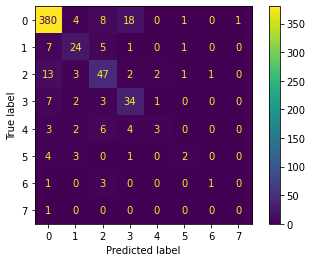

In [15]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7])
disp.plot()
plt.show()

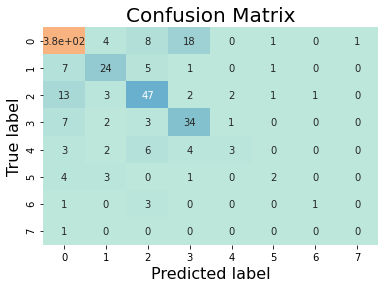

In [17]:
import seaborn as sns

plot = sns.heatmap(cm, annot=True, center=200.0, cbar=False)
plot.set_xticklabels([0,1,2,3,4,5,6,7])
plot.set_yticklabels([0,1,2,3,4,5,6,7])
plt.xlabel('Predicted label', fontsize=16)
plt.ylabel('True label', fontsize=16)
plot.set_title('Confusion Matrix', fontsize=20)
fig=plot.get_figure()
fig.savefig('confusion_matrix1.png')

In [ ]:
bootstrapping_acc = []
bootstrapping_mcc = []
bootstrapping_f1 = []
for i in range(1000):
    choice = pd.DataFrame(choices(test.to_numpy(), k=188))
    y_choice = choice[1025].to_numpy(dtype=int)
    X_choice = choice.drop(columns=[0, 1025])
    acc = classifier.score(X_choice, y_choice)
    mcc = matthews_corrcoef(y_choice, classifier.predict(X_choice))
    f1 =  f1_score(y_choice, classifier.predict(X_choice), average = 'weighted')
    bootstrapping_acc.append(acc)
    bootstrapping_mcc.append(mcc)
    bootstrapping_f1.append(f1)